In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import tables
import numpy as np
import os
from itertools import repeat
import random
import math
from tqdm import tqdm_notebook as tqdm
tqdm().pandas(desc="")
import sys, gc
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
import model_tuner
import scoring, utils

/Users/CL4US/.pyenv/versions/finowcast/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


## General Params

In [4]:
TYPES = dict(zip(utils.FULL_COLUMNS + utils.TRAIN_COLUMNS, repeat(np.float32)))
TYPES['id'] = np.uint64
TYPES['label'] = np.uint8
TEST_TYPES = dict(zip(utils.FULL_COLUMNS, repeat(np.float32)))

MATCHEDHIT_MISSING_COL = ['MatchedHit_X[2]', 'MatchedHit_X[3]', 'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 
                           'MatchedHit_Z[2]', 'MatchedHit_Z[3]', 'MatchedHit_DX[2]', 'MatchedHit_DX[3]', 
                           'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]'] # all those columns are not categorial data, YAY!
CLOSESTHIT_MISSING_COL = ['closest_x_per_station[2]', 'closest_x_per_station[3]', 
                    'closest_y_per_station[2]', 'closest_y_per_station[3]',
                    'closest_T_per_station[2]', 'closest_T_per_station[3]',
                    'closest_z_per_station[2]', 'closest_z_per_station[3]',
                    'closest_dx_per_station[2]', 'closest_dx_per_station[3]',
                    'closest_dy_per_station[2]', 'closest_dy_per_station[3]']

In [8]:
def make_Xdata(dataDF, additional_feature = 2, pangle = True, drop_FOI = True):
    # FOI related feature
    if additional_feature == 0:
        new_features = \
            dataDF[utils.FOI_COLUMNS].progress_apply(utils.parse_row, result_type="expand", axis=1)
    elif additional_feature == 1:
        new_features = \
            dataDF[['Lextra_{}[{}]'.format(x, i) for x in ['X', 'Y'] for i in range(4)] + utils.FOI_COLUMNS].progress_apply(utils.find_closest_hit_per_station, result_type="expand", axis=1)
        new_features.columns = utils.CLOSEST_HIT_FEATURE_COLUMNS
    elif additional_feature == 2:
        new_features = \
            dataDF[['Lextra_{}[{}]'.format(x, i) for x in ['X', 'Y'] for i in range(4)] + utils.FOI_COLUMNS].progress_apply(utils.add_foi_features, result_type="expand", axis=1)
        new_features.columns = utils.CLOSEST_HIT_FEATURE_COLUMNS + utils.AVERAGE_HIT_COLUMNS + utils.HIT_COUNT_COLUMNS
    print("additional features : DONE")
    
    # drop
    if drop_FOI:
        dataDF = pd.concat([dataDF[utils.SIMPLE_FEATURE_COLUMNS], new_features], axis=1)
    else:
        dataDF = pd.concat([dataDF, new_features], axis=1)
    print("drop : DONE")
    
    del new_features
    
    # imputation
    dataDF = replace_nan(dataDF)
    dataDF = missing_value_imputation(dataDF)
    print("data imputation : DONE")
    
    # original feature
    if pangle:
        dataDF["Pangle"] = dataDF["PT"] / dataDF["P"]
        dataDF["Pangle"] = dataDF["Pangle"].apply(lambda x: np.arcsin(x))
    print("original features : DONE")
    
    for station in range(2):
        delta = pd.DataFrame(index = dataDF.index)
        for axis in ['X', 'Y', 'Z']:
            delta[axis+'1'] = dataDF['MatchedHit_{}[{}]'.format(axis, station + 1)] - dataDF['MatchedHit_{}[{}]'.format(axis, station)]
            delta[axis+'2'] = dataDF['MatchedHit_{}[{}]'.format(axis, station + 2)] - dataDF['MatchedHit_{}[{}]'.format(axis, station+1)]
        delta = delta[['X1','Y1','Z1','X2','Y2','Z2']]
        dataDF['MAngle[{}]'.format(station)] = delta.progress_apply(lambda x: angle(x.values), axis=1)
    del delta
    
    gc.collect()
    return dataDF

In [9]:
def replace_nan(dataDF):
    for col in tqdm(MATCHEDHIT_MISSING_COL):
        dataDF[col] = dataDF[col].replace(-9999, np.nan)
#     for col in tqdm(CLOSESTHIT_MISSING_COL):
#         dataDF[col] = dataDF[col].replace(utils.EMPTY_FILLER, np.nan) 
    return dataDF
        
def missing_value_imputation(dataDF):
    imputation_dict = {
        'MatchedHit_X[2]':'Lextra_X[2]', 
        'MatchedHit_X[3]':'Lextra_X[3]', 
        'MatchedHit_Y[2]':'Lextra_Y[2]',
        'MatchedHit_Y[3]':'Lextra_Y[3]',
        'closest_x_per_station[2]':'Lextra_X[2]',
        'closest_x_per_station[3]':'Lextra_X[3]', 
        'closest_y_per_station[2]':'Lextra_Y[2]', 
        'closest_y_per_station[3]':'Lextra_Y[3]',
        'closest_T_per_station[2]':'MatchedHit_T[2]',
        'closest_T_per_station[3]':'MatchedHit_T[3]'
    }
    self_imputation_cols = ['MatchedHit_Z[2]', 'MatchedHit_Z[3]']
    for station in [2,3]: # Assume the ratio of DX(n+1)/DX(n) is the same
        MatchedHit_R = {}
        closesthit_R = {}
        for axis in ['X', 'Y', 'Z']:
            MatchedHit_R[axis] = \
            dataDF['MatchedHit_D{}[{}]'.format(axis,station)].dropna().median() / dataDF['MatchedHit_D{}[{}]'.format(axis,station-1)].dropna().median()
        for axis in ['x', 'y']:
            closesthit_R[axis] = \
            dataDF['closest_d{}_per_station[{}]'.format(axis,station)].dropna().median() / dataDF['closest_d{}_per_station[{}]'.format(axis,station-1)].dropna().median()
        for axis in ['X', 'Y', 'Z']:
            col = 'MatchedHit_D{}[{}]'.format(axis, station)
            col_prev = 'MatchedHit_D{}[{}]'.format(axis, station-1)
            ind_null = dataDF[col].isnull()
            dataDF.loc[ind_null, col] = dataDF.loc[ind_null, col_prev] * MatchedHit_R[axis]
        for axis in ['x', 'y']:
            col = 'closest_d{}_per_station[{}]'.format(axis,station)
            col_prev = 'closest_d{}_per_station[{}]'.format(axis,station-1)
            ind_null = dataDF[col].isnull()
            dataDF.loc[ind_null, col] = dataDF.loc[ind_null, col_prev] * closesthit_R[axis]
    
    for mcol in imputation_dict.keys():
        ind_null = dataDF[mcol].isnull()
        dataDF.loc[ind_null, mcol] = dataDF.loc[ind_null, imputation_dict[mcol]]
    
    for col in ['MatchedHit_Z[2]', 'MatchedHit_Z[3]', 'closest_z_per_station[2]', 'closest_z_per_station[3]']:
        ind_null = dataDF[col].isnull()
        dataDF.loc[ind_null, col] = dataDF.loc[ind_null.apply(lambda x: not x), col].mean()
    
    return dataDF

def angle(arr):
    x = arr[0:3]
    y = arr[3:]
    dot_xy = np.dot(x, y)
    norm_x = np.linalg.norm(x)
    norm_y = np.linalg.norm(y)
    cos = dot_xy / (norm_x*norm_y)
    rad = np.arccos(cos)
    theta = rad * 180 / np.pi
    return theta

def data_check(dataDF):
    print('checking data...')
    if not 'Pangle' in dataDF.columns:
        print('Pangle is missing')
        dataDF["Pangle"] = dataDF["PT"] / dataDF["P"]
        dataDF["Pangle"] = dataDF["Pangle"].apply(lambda x: np.arcsin(x))
    return dataDF

In [10]:
def feature_engineering(dataDF):
    station = 0
    delta = pd.DataFrame(index = dataDF.index)
    for axis in ['X', 'Y', 'Z']:
        delta[axis+'1'] = dataDF['MatchedHit_{}[{}]'.format(axis, station)]
        delta[axis+'2'] = dataDF['MatchedHit_{}[{}]'.format(axis, station + 1)] - dataDF['MatchedHit_{}[{}]'.format(axis, station)]
    delta = delta[['X1','Y1','Z1','X2','Y2','Z2']]
    dataDF['MAngle'] = delta.progress_apply(lambda x: angle(x.values), axis=1)
    
    for station in range(3):
        delta = pd.DataFrame(index = dataDF.index)
        for axis in ['X', 'Y', 'Z']:
            delta[axis+'1'] = dataDF['MatchedHit_{}[{}]'.format(axis, station + 1)] - dataDF['MatchedHit_{}[{}]'.format(axis, station)]
            delta[axis+'2'] = dataDF['Lextra_{}[{}]'.format(axis, station)] if axis != 'Z' else dataDF['MatchedHit_Z[{}]'.format(station)].mean()
        delta = delta[['X1','Y1','Z1','X2','Y2','Z2']]
        dataDF['MAngle_v2[{}]'.format(station)] = delta.progress_apply(lambda x: angle(x.values), axis=1)
    
    del delta
    gc.collect()
    
    
    for coord in ['X', 'Y']:
        for station in range(3):
            dataDF['Mextra_D{}2_R[{}]'.format(coord, station)] = \
                dataDF['Mextra_D{}2[{}]'.format(coord, station+1)] / dataDF['Mextra_D{}2[{}]'.format(coord, station)]
            
            dataDF['MatchedHit_D{}_R[{}]'.format(coord, station)] = \
                dataDF['MatchedHit_D{}[{}]'.format(coord, station+1)] / dataDF['MatchedHit_D{}[{}]'.format(coord, station)]
            
    for station in range(4):
        dataDF['MatchedHit_DXY[{}]'.format(station)] = \
            dataDF['MatchedHit_DX[{}]'.format(station)] + dataDF['MatchedHit_DY[{}]'.format(station)]
        
        dataDF['Mextra_DXY2[{}]'.format(station)] = \
            dataDF['Mextra_DX2[{}]'.format(station)] + dataDF['Mextra_DY2[{}]'.format(station)]
        
        dataDF['closest_xy_per_station[{}]'.format(station)] = \
            dataDF['closest_x_per_station[{}]'.format(station)] + dataDF['closest_y_per_station[{}]'.format(station)]
    
    for station in range(3):
        dataDF['MatchedHit_DXY_R[{}]'.format(station)] = \
            dataDF['MatchedHit_DXY[{}]'.format(station+1)] / dataDF['MatchedHit_DXY[{}]'.format(station)]
    
    dataDF['MAngle[01]_diff'] = dataDF['MAngle[1]'] - dataDF['MAngle[0]']
    dataDF['Pratio'] = dataDF['PT'] / dataDF['P']
    
    return dataDF

In [11]:
def feature_engineering_additinal(dataDF):
    for coord in ['X', 'Y']:
        for station in range(3):
            dataDF['MatchedHit_{}_diff[{}]'.format(coord, station)] = \
                dataDF['MatchedHit_{}[{}]'.format(coord, station+1)] - dataDF['MatchedHit_{}[{}]'.format(coord, station)]
    
    dataDF["closest_xy_average"] = (dataDF["closest_xy_per_station[0]"] + dataDF["closest_xy_per_station[1]"] + dataDF["closest_xy_per_station[2]"] + dataDF["closest_xy_per_station[3]"]) / 4
    dataDF["closest_x_average"] = (dataDF["closest_x_per_station[0]"] + dataDF["closest_x_per_station[1]"] + dataDF["closest_x_per_station[2]"] + dataDF["closest_x_per_station[3]"]) / 4
    dataDF["closest_y_average"] = (dataDF["closest_y_per_station[0]"] + dataDF["closest_y_per_station[1]"] + dataDF["closest_y_per_station[2]"] + dataDF["closest_y_per_station[3]"]) / 4
    
    dataDF["ncl_average"] = (dataDF["ncl[0]"] + dataDF["ncl[1]"] + dataDF["ncl[2]"] + dataDF["ncl[3]"]) / 4
    dataDF["avg_cs_average"] = (dataDF["avg_cs[0]"] + dataDF["avg_cs[1]"] + dataDF["avg_cs[2]"] + dataDF["avg_cs[3]"]) / 4
    
    for station in range(4):
        dataDF['average_xy_per_station[{}]'.format(station)] = \
            dataDF['average_x_per_station[{}]'.format(station)] + dataDF['average_y_per_station[{}]'.format(station)]

    return dataDF

In [12]:
def relu(x):
    return (x>0) * abs(x)

---

## From scratch

In [9]:
trn_data, test_data = utils.load_data_csv('01_rawdata/', utils.SIMPLE_FEATURE_COLUMNS + utils.FOI_COLUMNS, dtype = TYPES)

/Users/kevin/python-venv/def/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [10]:
del test_data
gc.collect()

21

In [ ]:
# Slice utils.TRAIN_COLUMNS
trn_data_wl = trn_data[utils.TRAIN_COLUMNS]

In [11]:
# Preprocess
trn_data = make_Xdata(trn_data[utils.SIMPLE_FEATURE_COLUMNS + utils.FOI_COLUMNS + utils.TRAIN_COLUMNS], additional_feature = 2)


additional features : DONE
drop : DONE



data imputation : DONE
original features : DONE


/Users/kevin/python-venv/def/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in arccos


In [12]:
trn_data.columns.values

array(['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]',
       'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
       'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
       'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
       'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
       'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
       'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
       'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
       'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]',
       'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]',
       'Lextra_X[1]', 'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]',
       '

In [13]:
# feature engineering 1
trn_data = feature_engineering(trn_data)

/Users/kevin/python-venv/def/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in arccos


In [ ]:
trn_data = pd.concat([trn_data, trn_data_wl], axis=1)

---

### to/read hdf

In [14]:
trn_data.to_hdf("../data/trn_mXd_fe_best.hdf", key="data")

In [15]:
# load hdf
#trn_data = pd.read_hdf("../data/trn_mXd_fe_best.hdf", key="data")

---

In [79]:
trn_data.to_hdf("../data/trn_154col.hdf", key="data")

In [78]:
print(trn_data.shape)
trn_data.columns.values
#trn_data.to_hdf
def data_check2(dataDF):
    print(dataDF.shape)
    null_col = []
    for col in tqdm(trn_data.columns, desc='checking data...,'):
        ind_null = trn_data[col].isnull()
        if ind_null.sum() == 0:
            continue
        print('{}: {} null items found'.format(col, ind_null.sum()))
        null_col.append(col)
        display(trn_data.loc[ind_null, col].head(5))
    return null_col

data_check2(trn_data)
trn_data

(5445705, 154)
(5445705, 154)


average_x_per_station[2]: 89718 null items found


11    NaN
23    NaN
90    NaN
125   NaN
137   NaN
Name: average_x_per_station[2], dtype: float32

average_x_per_station[3]: 97974 null items found


23    NaN
90    NaN
125   NaN
161   NaN
187   NaN
Name: average_x_per_station[3], dtype: float32

average_y_per_station[2]: 89718 null items found


11    NaN
23    NaN
90    NaN
125   NaN
137   NaN
Name: average_y_per_station[2], dtype: float32

average_y_per_station[3]: 97974 null items found


23    NaN
90    NaN
125   NaN
161   NaN
187   NaN
Name: average_y_per_station[3], dtype: float32

MAngle[0]: 463 null items found


3408    NaN
31835   NaN
65111   NaN
77855   NaN
92299   NaN
Name: MAngle[0], dtype: float64

MAngle[1]: 183 null items found


6451     NaN
69613    NaN
116179   NaN
152995   NaN
194438   NaN
Name: MAngle[1], dtype: float64

MAngle: 2389 null items found


1145   NaN
1155   NaN
1774   NaN
8547   NaN
9818   NaN
Name: MAngle, dtype: float64

MAngle_v2[0]: 2634 null items found


2163    NaN
4530    NaN
8692    NaN
10639   NaN
17137   NaN
Name: MAngle_v2[0], dtype: float64

MAngle_v2[1]: 7 null items found


1692114   NaN
1736910   NaN
2162272   NaN
3561677   NaN
3944462   NaN
Name: MAngle_v2[1], dtype: float64

MAngle_v2[2]: 3119 null items found


568    NaN
1460   NaN
2545   NaN
2925   NaN
3810   NaN
Name: MAngle_v2[2], dtype: float64

MAngle[01]_diff: 645 null items found


3408    NaN
6451    NaN
31835   NaN
65111   NaN
69613   NaN
Name: MAngle[01]_diff, dtype: float64

average_xy_per_station[2]: 89718 null items found


11    NaN
23    NaN
90    NaN
125   NaN
137   NaN
Name: average_xy_per_station[2], dtype: float32

average_xy_per_station[3]: 97974 null items found


23    NaN
90    NaN
125   NaN
161   NaN
187   NaN
Name: average_xy_per_station[3], dtype: float32

['average_x_per_station[2]',
 'average_x_per_station[3]',
 'average_y_per_station[2]',
 'average_y_per_station[3]',
 'MAngle[0]',
 'MAngle[1]',
 'MAngle',
 'MAngle_v2[0]',
 'MAngle_v2[1]',
 'MAngle_v2[2]',
 'MAngle[01]_diff',
 'average_xy_per_station[2]',
 'average_xy_per_station[3]']

In [28]:
print(trn_data.shape)
trn_data.columns.values

(5445705, 152)


array(['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]',
       'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
       'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
       'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
       'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
       'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
       'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
       'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
       'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]',
       'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]',
       'Lextra_X[1]', 'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]',
       '

In [18]:
# feature engineering 2
trn_data = feature_engineering_additinal(trn_data)

In [19]:
print(trn_data.shape)
trn_data.columns.values

(5445705, 152)


array(['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]',
       'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
       'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
       'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
       'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
       'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
       'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
       'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
       'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]',
       'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]',
       'Lextra_X[1]', 'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]',
       '

-----

## Preparation for Learning

In [30]:
x_columns = utils.SIMPLE_FEATURE_COLUMNS + utils.CLOSEST_HIT_FEATURE_COLUMNS \
          + ["Pangle", "FOI_hits_S_0", #"FOI_hits_S_1", "FOI_hits_S_2", "FOI_hits_S_3", \
             "average_x_per_station[0]", "average_x_per_station[1]", "average_x_per_station[2]", "average_x_per_station[3]", \
             "average_y_per_station[0]", "average_y_per_station[1]", "average_y_per_station[2]", "average_y_per_station[3]", \
             'MAngle[0]', 'MAngle[1]', 'MAngle', 
             'Mextra_DX2_R[0]', 'Mextra_DX2_R[1]', 'Mextra_DX2_R[2]', 
             'Mextra_DY2_R[0]', 'Mextra_DY2_R[1]', 'Mextra_DY2_R[2]',
             'MatchedHit_DX_R[0]', 'MatchedHit_DX_R[1]', 'MatchedHit_DX_R[2]',
             'MatchedHit_DY_R[0]', 'MatchedHit_DY_R[1]', 'MatchedHit_DY_R[2]',
             'MAngle_v2[0]', 'MAngle_v2[1]', 'MAngle_v2[2]', 
             'MatchedHit_DXY_R[0]', 'MatchedHit_DXY_R[1]', 'MatchedHit_DXY_R[2]',
             'MatchedHit_DXY[0]', 'MatchedHit_DXY[1]', 'MatchedHit_DXY[2]', 'MatchedHit_DXY[3]', 
             'Mextra_DXY2[0]', 'Mextra_DXY2[1]', 'Mextra_DXY2[2]', 'Mextra_DXY2[3]', 
             'closest_xy_per_station[0]', 'closest_xy_per_station[1]', 'closest_xy_per_station[2]', 'closest_xy_per_station[3]', 
             'MAngle[01]_diff', 'Pratio', 
#              'MatchedHit_X_diff[0]', 'MatchedHit_X_diff[1]', 'MatchedHit_X_diff[2]', 
#              'MatchedHit_Y_diff[0]', 'MatchedHit_Y_diff[1]', 'MatchedHit_Y_diff[2]',
#              'average_x_per_station_v2[0]', 'average_x_per_station_v2[1]', 'average_x_per_station_v2[2]', 'average_x_per_station_v2[3]',
#              'average_y_per_station_v2[0]', 'average_y_per_station_v2[1]', 'average_y_per_station_v2[2]', 'average_y_per_station_v2[3]',
#              'average_T_per_station[0]', 'average_T_per_station[1]', 'average_T_per_station[2]', 'average_T_per_station[3]',
#              'average_z_per_station[0]', 'average_z_per_station[1]', 'average_z_per_station[2]', 'average_z_per_station[3]',
#              'average_dx_per_station[0]', 'average_dx_per_station[1]', 'average_dx_per_station[2]', 'average_dx_per_station[3]',
#              'average_dy_per_station[0]', 'average_dy_per_station[1]', 'average_dy_per_station[2]', 'average_dy_per_station[3]'
             'closest_xy_average', 'closest_x_average', 'closest_y_average', 'ncl_average', 'avg_cs_average', 
             'average_xy_per_station[0]', 'average_xy_per_station[1]', 'average_xy_per_station[2]', 'average_xy_per_station[3]'
            ]

drop_columns = ['closest_T_per_station[0]','closest_T_per_station[1]','closest_T_per_station[2]','closest_T_per_station[3]',
                'MatchedHit_DX_R[0]','MatchedHit_DX_R[1]','MatchedHit_DX_R[2]',
                'MatchedHit_DY_R[0]','MatchedHit_DY_R[1]','MatchedHit_DY_R[2]',
                'Mextra_DXY2[0]','Mextra_DXY2[1]','Mextra_DXY2[2]','Mextra_DXY2[3]',
                'MAngle[01]_diff','Pratio','FOI_hits_S_0']

In [31]:
len(x_columns), len(drop_columns)

(143, 17)

In [32]:
trn_data_trn, trn_data_eval = \
    train_test_split(trn_data, test_size=0.25, shuffle=True, random_state=11)

In [33]:
trn_data_trn[trn_data_trn["weight"] < 0]["label"].value_counts()

1    521138
0     61470
Name: label, dtype: int64

In [34]:
def weight_flipper(data):
    ind_negative = (data['weight'] < 0)
    
    ind_label0_negative = (data["weight"] > -4000) & (data['weight'] < 0) & (data["label"] == 0)
    data.loc[ind_label0_negative, 'weight'] = data['weight'].map(lambda x: 2.0 * x)
    
    data.loc[ind_negative, 'weight'] = data['weight'].map(lambda x: -1.0 * x)
    data.loc[ind_negative, 'label'] = data['label'].map(lambda x: 1-x)

    return data

In [35]:
trn_data_trn[utils.TRAIN_COLUMNS] = weight_flipper(trn_data_trn[utils.TRAIN_COLUMNS])

/Users/kevin/python-venv/def/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/kevin/python-venv/def/lib/python3.7/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [36]:
trn_data_trn[trn_data_trn["weight"] < 0]

,ncl[0],ncl[1],ncl[2],ncl[3],avg_cs[0],avg_cs[1],avg_cs[2],avg_cs[3],ndof,MatchedHit_TYPE[0],...,closest_x_average,closest_y_average,ncl_average,avg_cs_average,average_xy_per_station[0],average_xy_per_station[1],average_xy_per_station[2],average_xy_per_station[3],label,weight


In [37]:
trn_data_trn.shape

(4084278, 154)

In [38]:
x_train = trn_data_trn[x_columns]
#x_train = trn_data_trn[x_columns].drop(drop_columns, axis=1)
y_train = trn_data_trn["label"]
w_train = trn_data_trn["weight"].map(relu)

In [39]:
x_eval = trn_data_eval[x_columns]
#x_eval = trn_data_eval[x_columns].drop(drop_columns, axis=1)
y_eval = trn_data_eval["label"]
w_eval = trn_data_eval["weight"].map(relu)

In [40]:
del trn_data_trn
del trn_data_eval
gc.collect()

7

-----

## Learning

In [41]:
x_train.shape, x_eval.shape

((4084278, 143), (1361427, 143))

In [42]:
x_train.columns.values

array(['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]',
       'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
       'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
       'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
       'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
       'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
       'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
       'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
       'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]',
       'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]',
       'Lextra_X[1]', 'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]',
       '

In [43]:
train_data = Pool(
    data = x_train.values,
    label = y_train.values,
    weight = w_train.values
)
eval_data = Pool(
    data = x_eval.values,
    label = y_eval.values,
    weight = w_eval.values
)

In [44]:
# ID: 19244362
# score: 7717.56
# weight flip
# label0, -4000<w<0 : x2
cat = CatBoostRegressor(iterations=5000, use_best_model=True, one_hot_max_size=5, thread_count=6, 
                        depth=7, bagging_temperature=0.2, random_strength=40, random_state=11)
cat.fit(X=train_data, eval_set=eval_data, plot=True, early_stopping_rounds=20, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

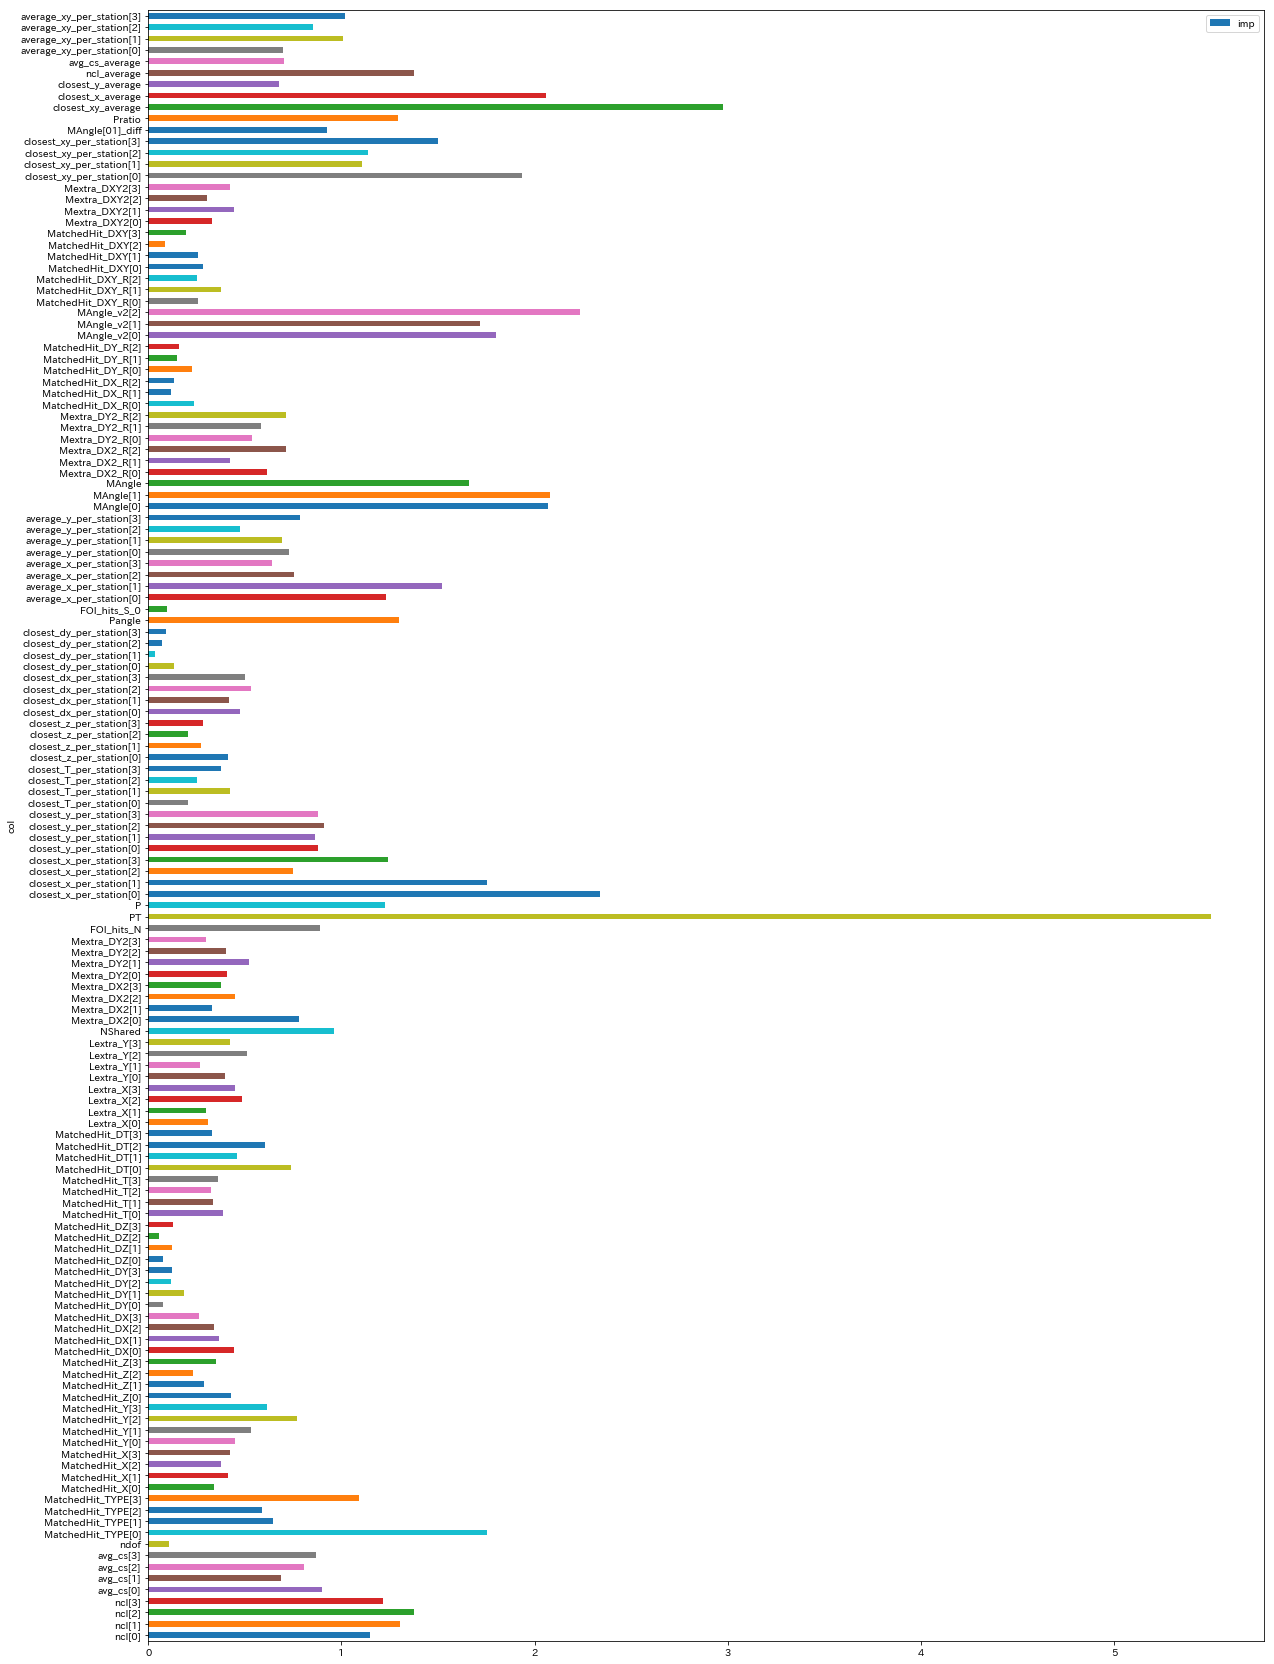

In [45]:
# ID: 19244362
# score: 7717.56
importance = pd.DataFrame({'imp': cat.feature_importances_, 'col': x_eval.columns})
_ = importance.plot(kind='barh', x='col', y='imp', figsize=(20, 30))

-----

## Evaluation

In [46]:
# ID: 19244362
# score: 7717.56
pred = cat.predict(x_eval)
scoring.rejection90(y_eval, pred, sample_weight=trn_data.loc[x_eval.index, "weight"].values)
#scoring.rejection90(y_cv_test, pred, sample_weight=w_train_raw[x_cv_test.index].values)

0.78829217

In [47]:
validation = pd.concat([trn_data.loc[w_eval.index, "weight"], pd.DataFrame(pred, columns=["pred"], index=y_eval.index)], axis=1)
validation = validation.reset_index()

In [48]:
validation.sort_values("pred", ascending=False).head()

,index,weight,pred
1082802,2009963,4.641108,1.265747
193817,4623802,2.262566,1.261967
789009,2747126,3.202868,1.246756
1129588,4076191,2.059985,1.239037
135375,4902102,1.971759,1.234152


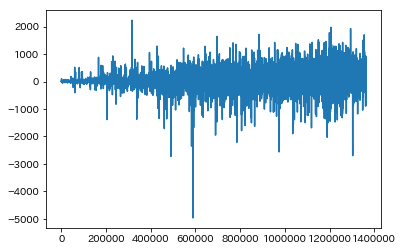

In [50]:
# ID: 19244362
# score: 7717.56
validation.sort_values("pred", ascending=False).reset_index()["weight"].plot()

-----

## Make test data

In [51]:
_data, test_data = utils.load_data_csv('../data', utils.SIMPLE_FEATURE_COLUMNS + utils.FOI_COLUMNS, dtype = TYPES)

/Users/kevin/python-venv/def/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [52]:
del _data
gc.collect()

36

In [53]:
test_data = make_Xdata(test_data[utils.SIMPLE_FEATURE_COLUMNS + utils.FOI_COLUMNS], additional_feature = 2)


additional features : DONE
drop : DONE



data imputation : DONE
original features : DONE


/Users/kevin/python-venv/def/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in arccos


In [54]:
test_data = feature_engineering(test_data)

/Users/kevin/python-venv/def/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in arccos


In [55]:
test_data.to_hdf("../data/test_mXd_fe_best.hdf", key="data")

In [ ]:
#test_data = pd.read_hdf("../data/test_mXd_fe_best.hdf", key="data")

In [ ]:
#x_test = feature_engineering_additinal(x_test)

In [57]:
test_data = feature_engineering_additinal(test_data)

-----

## Submission

In [58]:
test_data[x_train.columns].shape

(726095, 143)

In [60]:
pred = cat.predict(test_data[x_train.columns])
submission = pd.DataFrame(index=test_data.index, data=pred)
submission.columns = ['prediction']
submission.index.name = "id"

In [61]:
print(submission.shape)
submission.head(10)

(726095, 1)


,prediction
id,
0,0.874276
1,0.685422
2,0.779846
3,0.699824
4,0.892662
5,0.641267
6,0.677116
7,0.567298
8,0.622801


In [62]:
submission.to_csv('submission_best.csv')

-----

## Save Data & Model

In [63]:
cat.save_model('02_models/A_best_model.cbm')

-----

## TEST - PRIVATE
### *WE MADE A BIG MISTAKE HERE*
- We did not check the structure of hdf file distributed by the official, where FOI features are already parsed as array. So we tried to re-parse them and it brought us disaster.

In [64]:
test_private = pd.read_hdf("../data/test_private_v2_track_1.hdf")

In [65]:
test_private.shape

(1452188, 74)

In [66]:
test_private = make_Xdata(test_private[utils.SIMPLE_FEATURE_COLUMNS + utils.FOI_COLUMNS], additional_feature = 2)


additional features : DONE
drop : DONE



data imputation : DONE
original features : DONE


/Users/kevin/python-venv/def/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in arccos


In [67]:
test_private = feature_engineering(test_private)

/Users/kevin/python-venv/def/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in arccos


In [68]:
test_private.to_hdf("../data/test_private_mXD_fe_best.hdf", key="data")

In [ ]:
#test_private = pd.read_hdf("../data/test_private_mXD_fe_best.hdf", key="data")

In [69]:
print(test_private.shape)
test_private.columns.values

(1452188, 137)


array(['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]',
       'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
       'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
       'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
       'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
       'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
       'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
       'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
       'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]',
       'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]',
       'Lextra_X[1]', 'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]',
       '

In [70]:
test_private = feature_engineering_additinal(test_private)

In [72]:
print(test_private.shape)
test_private.columns.values

(1452188, 152)


array(['ncl[0]', 'ncl[1]', 'ncl[2]', 'ncl[3]', 'avg_cs[0]', 'avg_cs[1]',
       'avg_cs[2]', 'avg_cs[3]', 'ndof', 'MatchedHit_TYPE[0]',
       'MatchedHit_TYPE[1]', 'MatchedHit_TYPE[2]', 'MatchedHit_TYPE[3]',
       'MatchedHit_X[0]', 'MatchedHit_X[1]', 'MatchedHit_X[2]',
       'MatchedHit_X[3]', 'MatchedHit_Y[0]', 'MatchedHit_Y[1]',
       'MatchedHit_Y[2]', 'MatchedHit_Y[3]', 'MatchedHit_Z[0]',
       'MatchedHit_Z[1]', 'MatchedHit_Z[2]', 'MatchedHit_Z[3]',
       'MatchedHit_DX[0]', 'MatchedHit_DX[1]', 'MatchedHit_DX[2]',
       'MatchedHit_DX[3]', 'MatchedHit_DY[0]', 'MatchedHit_DY[1]',
       'MatchedHit_DY[2]', 'MatchedHit_DY[3]', 'MatchedHit_DZ[0]',
       'MatchedHit_DZ[1]', 'MatchedHit_DZ[2]', 'MatchedHit_DZ[3]',
       'MatchedHit_T[0]', 'MatchedHit_T[1]', 'MatchedHit_T[2]',
       'MatchedHit_T[3]', 'MatchedHit_DT[0]', 'MatchedHit_DT[1]',
       'MatchedHit_DT[2]', 'MatchedHit_DT[3]', 'Lextra_X[0]',
       'Lextra_X[1]', 'Lextra_X[2]', 'Lextra_X[3]', 'Lextra_Y[0]',
       '

In [80]:
test_private[x_train.columns].shape

(1452188, 143)

In [81]:
pred_private = cat.predict(test_private[x_train.columns])
submission_private = pd.DataFrame(index=test_private.index, data=pred_private)
submission_private.columns = ['prediction']
submission_private.index.name = "id"

In [82]:
print(submission_private.shape)
submission_private.head(10)

(1452188, 1)


,prediction
id,
0,0.707127
1,0.879114
2,0.799392
3,0.805297
4,0.669011
5,0.743160
6,0.911361
7,0.770120
8,0.768401


In [83]:
submission_private.to_csv('submission_private.csv')